In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import os


from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     /storage-1T/home/yunrui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /storage-1T/home/yunrui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /storage-1T/home/yunrui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
def data_cleaning(text):
    # 大小写
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [3]:
!pwd
data_folder_path = './data/'
df = pd.read_csv(data_folder_path + 'train.csv')
test_text = pd.read_csv(data_folder_path + 'test.csv')
test_label = pd.read_csv(data_folder_path + 'test_labels.csv')
test_df = pd.concat([test_text, test_label], axis=1)
classes = ['abo']

/storage-6T/yunrui/comp9444/toxic-comment-classification


In [4]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)
test_df['comment_text'] = test_df['comment_text'].apply(data_cleaning)

# make it a binary classifcation

# do it on training set
df['abo'] = 0
for a in range(0, len(df)):
    if (df.iloc[a]['toxic'] == 1) | (df.iloc[a]['severe_toxic'] == 1) | (df.iloc[a]['obscene'] == 1) | (df.iloc[a]['threat'] == 1) | (df.iloc[a]['insult'] == 1) | (df.iloc[a]['identity_hate'] == 1):
        df.at[a, 'abo'] = 1
df.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis = 1, inplace = True)

# drop the -1s in testing set
ids_to_drop = []
for i in range(len(test_df)):
    if (test_df['toxic'][i] == -1 or test_df['severe_toxic'][i] == -1 or test_df['obscene'][i] == -1 or test_df['threat'][i] == -1 or test_df['insult'][i] == -1 or test_df['identity_hate'][i] == -1):
        ids_to_drop.append(i)

test_df = test_df.drop(ids_to_drop)
test_df.reset_index(inplace = True, drop = True)

test_df['abo'] = 0
for a in range(0, len(test_df)):
    if (test_df.iloc[a]['toxic'] == 1) | (test_df.iloc[a]['severe_toxic'] == 1) | (test_df.iloc[a]['obscene'] == 1) | (test_df.iloc[a]['threat'] == 1) | (test_df.iloc[a]['insult'] == 1) | (test_df.iloc[a]['identity_hate'] == 1):
        test_df.at[a, 'abo'] = 1
test_df.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis = 1, inplace = True)
df = df.dropna()
test_df = test_df.dropna()

In [5]:
total_train_toxic = df.abo.sum()
total_test_toxic = test_df.abo.sum()

In [6]:
print(f"train toxic : {total_train_toxic}")
print(f"test toxic : {total_test_toxic}")

print(f"training set percentage {total_train_toxic/len(df)}")
print(f"testing set percentage {total_test_toxic/len(test_df)}")

train toxic : 16225
test toxic : 6243
training set percentage 0.10167887648758234
testing set percentage 0.09758041826877989


In [7]:
test_df

,id,comment_text,id,abo
0,0001ea8717f6de06,Thank you for understanding I think very highl...,0001ea8717f6de06,0
1,000247e83dcc1211,:Dear god this site is horrible,000247e83dcc1211,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0002f87b16116a7f,0
3,0003e1cccfd5a40a,""" It says it even in Binghamton University,...",0003e1cccfd5a40a,0
4,00059ace3e3e9a53,""" == Before adding a new product to the lis...",00059ace3e3e9a53,0
...,...,...,...,...
63973,fff8f64043129fa2,":Jerome, I see you never got around to this ef...",fff8f64043129fa2,0
63974,fff9d70fe0722906,==Lucky bastard== _releases/English_Wikipedi...,fff9d70fe0722906,0
63975,fffa8a11c4378854,==shame on you all!== You want to speak abo...,fffa8a11c4378854,0
63976,fffac2a094c8e0e2,MEL GIBSON IS ASSHOLE IS NOW BIG ENOUGH TO BE ...,fffac2a094c8e0e2,1


In [10]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [11]:
from torchtext.vocab import GloVe, vocab

unk_token = "<pad>"
unk_index = 0
#name = "vector_cache"


if os.path.isdir("./.vector_cache"):
    glove_vectors = GloVe(name = 'twitter.27B', cache = './.vector_cache', dim=200)
else:    
    glove_vectors = GloVe('twitter.27B', dim=200)
print(len(glove_vectors.stoi))
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
print(pretrained_embeddings.shape)


1193514
torch.Size([1193515, 200])


In [12]:
from torch.utils.data import IterableDataset

tokenizer = get_tokenizer("basic_english")



class MyDataset(Dataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token
         # self.unk_token = unk_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]

        diff = self.max_len - len(tokens)
        # print('diff',diff)
        if diff > 0:

            tokens = [self.pad_token] * diff + tokens
            # print('tokens',to
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result


In [13]:
MAX_LEN = 0
for a in range(0 , len(df)):
    f = df["comment_text"][a]
    length = len(f.split())
    if length > MAX_LEN:
        MAX_LEN = length
        
train_dataset = MyDataset(df, MAX_LEN)
test_dataset = MyDataset(test_df, MAX_LEN)

In [15]:
for data in test_dataset:
    print(data['text'])
    print(data['labels'])
    print(data['indices'])
    break

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

In [16]:


class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = False):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=3, bidirectional=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)

        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)
        
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out

In [18]:
## OK let's try to run this model to see if dimensions are correct!
#glove_model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=64, is_batch=False)

#for idx, data in enumerate(train_dataset):
#    print("---------------------------------")
#    print('next example id ', idx)
#    print("---------------------------------")
#    # example_text = data['text']
#    text_input = data['indices']
    # print('tensor_shape: ', text_input.shape)
#    model_output = glove_model(text_input)
    # fwd = glove_model.forward(text_input)
    # print('embedding_bag: ',  fwd.shape)
    # print('output_shape: ', model_output.shape)
#    print('output: ', model_output)

    #if idx == 2:
#    break

In [19]:
from torch.utils.data import DataLoader


BATCH_SIZE = 350

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [23]:
target_name = ['Normal', "Toxic"]

In [24]:
for batch_id, batch in enumerate(test_dataloader):
    print(batch)
    break

{'text': [('<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

Let's use 4 GPUs!
              precision    recall  f1-score   support

      Normal       0.92      0.99      0.95     57735
       Toxic       0.72      0.15      0.25      6243

    accuracy                           0.91     63978
   macro avg       0.82      0.57      0.60     63978
weighted avg       0.90      0.91      0.88     63978

Epoch: 0 Train_Loss: 0.29822311011192043 Train_Accuracy: 0.15026956796646118
Epoch: 0 Test_Loss: 0.25524233436323907 Test_Accuracy: 0.15188033878803253


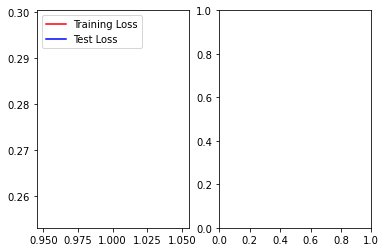

              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96     57735
       Toxic       0.75      0.28      0.41      6243

    accuracy                           0.92     63978
   macro avg       0.84      0.63      0.68     63978
weighted avg       0.91      0.92      0.90     63978

Epoch: 1 Train_Loss: 0.22572901047635496 Train_Accuracy: 0.15343430638313293
Epoch: 1 Test_Loss: 0.2213272640451056 Test_Accuracy: 0.1534668207168579


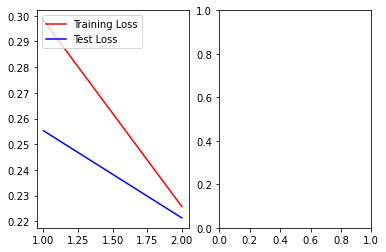

              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96     57735
       Toxic       0.76      0.33      0.46      6243

    accuracy                           0.92     63978
   macro avg       0.85      0.66      0.71     63978
weighted avg       0.92      0.92      0.91     63978

Epoch: 2 Train_Loss: 0.1946079196375713 Train_Accuracy: 0.15520572662353516
Epoch: 2 Test_Loss: 0.20512900415991173 Test_Accuracy: 0.15412069857120514


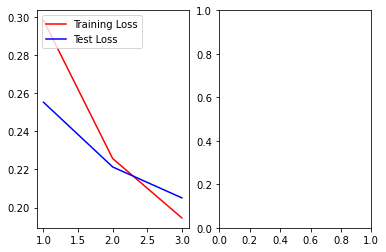

              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96     57735
       Toxic       0.66      0.49      0.56      6243

    accuracy                           0.93     63978
   macro avg       0.80      0.73      0.76     63978
weighted avg       0.92      0.93      0.92     63978

Epoch: 3 Train_Loss: 0.17631160208073102 Train_Accuracy: 0.15613007545471191
Epoch: 3 Test_Loss: 0.2030507879016178 Test_Accuracy: 0.15427960455417633


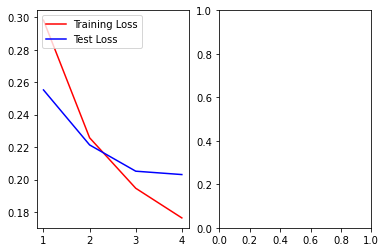

              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96     57735
       Toxic       0.66      0.54      0.59      6243

    accuracy                           0.93     63978
   macro avg       0.80      0.75      0.78     63978
weighted avg       0.92      0.93      0.92     63978

Epoch: 4 Train_Loss: 0.16116029439134555 Train_Accuracy: 0.15705756843090057
Epoch: 4 Test_Loss: 0.2008565279955421 Test_Accuracy: 0.15456876158714294


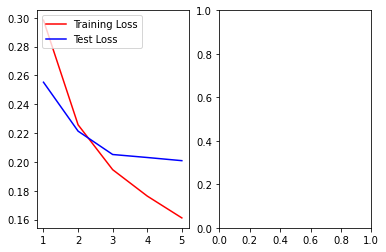

              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96     57735
       Toxic       0.65      0.59      0.62      6243

    accuracy                           0.93     63978
   macro avg       0.80      0.78      0.79     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 5 Train_Loss: 0.14980656230462747 Train_Accuracy: 0.15755681693553925
Epoch: 5 Test_Loss: 0.2070085368846935 Test_Accuracy: 0.15480582416057587


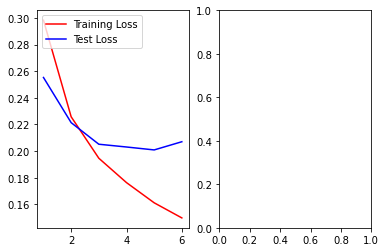

              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96     57735
       Toxic       0.68      0.57      0.62      6243

    accuracy                           0.93     63978
   macro avg       0.82      0.77      0.79     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 6 Train_Loss: 0.13999707473997483 Train_Accuracy: 0.15816783905029297
Epoch: 6 Test_Loss: 0.19532585490108187 Test_Accuracy: 0.15543363988399506


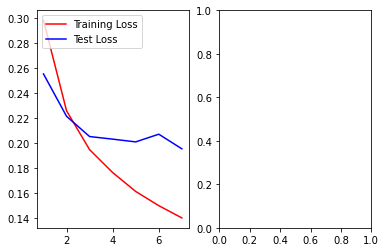

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96     57735
       Toxic       0.62      0.66      0.64      6243

    accuracy                           0.93     63978
   macro avg       0.79      0.81      0.80     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 7 Train_Loss: 0.13241029769312918 Train_Accuracy: 0.15865246951580048
Epoch: 7 Test_Loss: 0.2149347834736923 Test_Accuracy: 0.1546599417924881


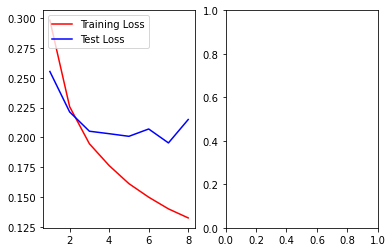

              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96     57735
       Toxic       0.67      0.61      0.64      6243

    accuracy                           0.93     63978
   macro avg       0.81      0.79      0.80     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 8 Train_Loss: 0.1273849188235768 Train_Accuracy: 0.15896372497081757
Epoch: 8 Test_Loss: 0.19699944205622855 Test_Accuracy: 0.1554701179265976


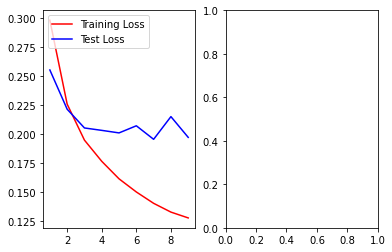

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96     57735
       Toxic       0.66      0.64      0.65      6243

    accuracy                           0.93     63978
   macro avg       0.81      0.80      0.81     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 9 Train_Loss: 0.12047038884964167 Train_Accuracy: 0.15937002003192902
Epoch: 9 Test_Loss: 0.19320181883423707 Test_Accuracy: 0.15544666349887848


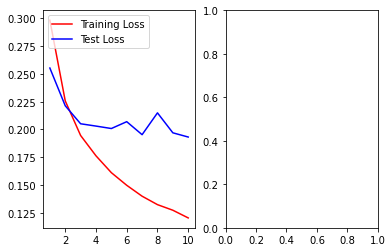

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96     57735
       Toxic       0.63      0.67      0.65      6243

    accuracy                           0.93     63978
   macro avg       0.80      0.81      0.81     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 10 Train_Loss: 0.11561116009231723 Train_Accuracy: 0.15965202450752258
Epoch: 10 Test_Loss: 0.20195116697113372 Test_Accuracy: 0.15502986311912537


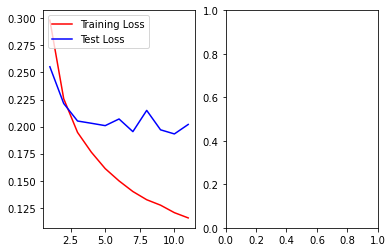

              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96     57735
       Toxic       0.67      0.64      0.66      6243

    accuracy                           0.93     63978
   macro avg       0.82      0.80      0.81     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 11 Train_Loss: 0.11126978903714764 Train_Accuracy: 0.15993715822696686
Epoch: 11 Test_Loss: 0.18906592585838558 Test_Accuracy: 0.15571759641170502


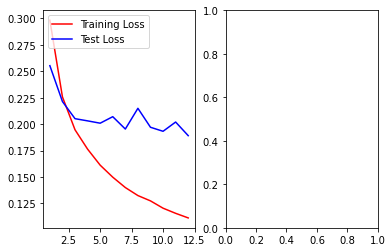

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96     57735
       Toxic       0.65      0.67      0.66      6243

    accuracy                           0.93     63978
   macro avg       0.81      0.82      0.81     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 12 Train_Loss: 0.10750932907358858 Train_Accuracy: 0.16011472046375275
Epoch: 12 Test_Loss: 0.19389856830646432 Test_Accuracy: 0.15535028278827667


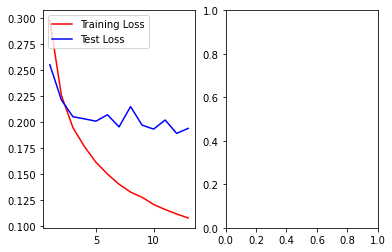

              precision    recall  f1-score   support

      Normal       0.97      0.93      0.95     57735
       Toxic       0.56      0.77      0.64      6243

    accuracy                           0.92     63978
   macro avg       0.76      0.85      0.80     63978
weighted avg       0.93      0.92      0.92     63978

Epoch: 13 Train_Loss: 0.1035021347679982 Train_Accuracy: 0.1604102998971939
Epoch: 13 Test_Loss: 0.2535353316798236 Test_Accuracy: 0.1529119461774826


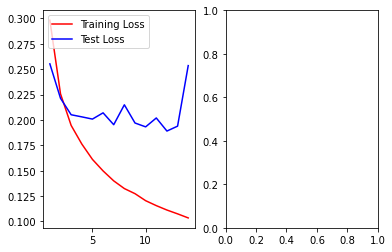

              precision    recall  f1-score   support

      Normal       0.97      0.94      0.96     57735
       Toxic       0.57      0.75      0.65      6243

    accuracy                           0.92     63978
   macro avg       0.77      0.85      0.80     63978
weighted avg       0.93      0.92      0.93     63978

Epoch: 14 Train_Loss: 0.10022122533828542 Train_Accuracy: 0.1605345904827118
Epoch: 14 Test_Loss: 0.24108804689079036 Test_Accuracy: 0.15353195369243622


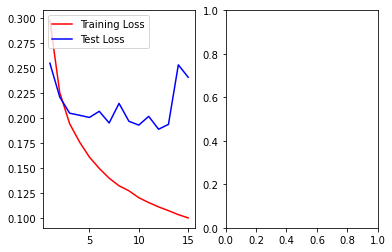

              precision    recall  f1-score   support

      Normal       0.97      0.94      0.96     57735
       Toxic       0.59      0.74      0.66      6243

    accuracy                           0.92     63978
   macro avg       0.78      0.84      0.81     63978
weighted avg       0.93      0.92      0.93     63978

Epoch: 15 Train_Loss: 0.09719033286040812 Train_Accuracy: 0.16071738302707672
Epoch: 15 Test_Loss: 0.22148612239321724 Test_Accuracy: 0.15407902002334595


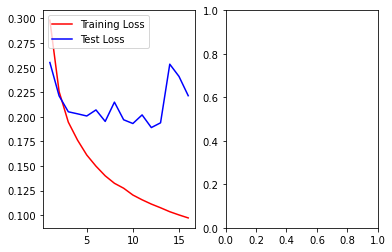

              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96     57735
       Toxic       0.64      0.69      0.66      6243

    accuracy                           0.93     63978
   macro avg       0.80      0.82      0.81     63978
weighted avg       0.93      0.93      0.93     63978

Epoch: 16 Train_Loss: 0.09392425323950879 Train_Accuracy: 0.16087613999843597
Epoch: 16 Test_Loss: 0.1937761068995533 Test_Accuracy: 0.15518876910209656


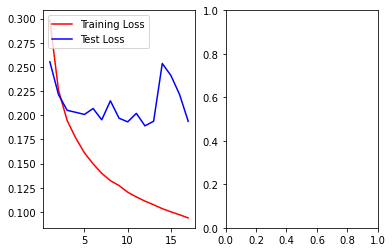

              precision    recall  f1-score   support

      Normal       0.97      0.94      0.96     57735
       Toxic       0.58      0.75      0.66      6243

    accuracy                           0.92     63978
   macro avg       0.78      0.85      0.81     63978
weighted avg       0.93      0.92      0.93     63978

Epoch: 17 Train_Loss: 0.09155796678213958 Train_Accuracy: 0.16108398139476776
Epoch: 17 Test_Loss: 0.22853636505499564 Test_Accuracy: 0.15392270684242249


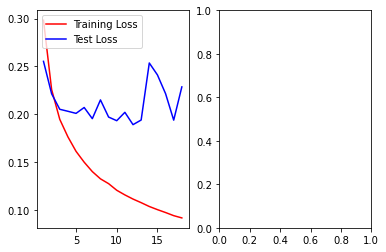

              precision    recall  f1-score   support

      Normal       0.97      0.94      0.96     57735
       Toxic       0.58      0.76      0.66      6243

    accuracy                           0.92     63978
   macro avg       0.77      0.85      0.81     63978
weighted avg       0.93      0.92      0.93     63978

Epoch: 18 Train_Loss: 0.0884142408899048 Train_Accuracy: 0.1612396091222763
Epoch: 18 Test_Loss: 0.2273486724805311 Test_Accuracy: 0.153677836060524


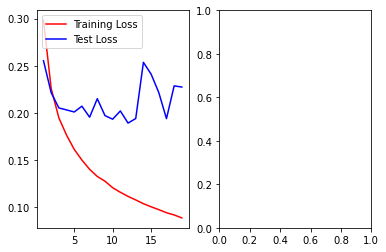

In [ ]:
from IPython.display import clear_output
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
weights = []
for cls in classes:
    w = len(df) /df[cls].sum()
    weights.append(w)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor((175796 - 35098*2) / 35098*2))
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=128)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")
    # model = torch.nn.DataParallel(model)    # multi-gpu

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.0001)

epochs = 50

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        #print('ids: ', ids.shape)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)
        #print('loss: ', loss)

        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        # if batch_id % 100 == 0:
            # print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss.item()))
            #print(loss.grad_fn)

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = correct_predictions/(len(df)*6)


    if e % 3000 == 0 and e != 0:
        torch.save(model.state_dict(), 'model_epoch_{}.pt'.format(e))

    ## Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        predictions_store = []
        labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                predictions_store.append(preds[i])
                labels_store.append(labels[i])

        # print(pred_counter, label_counter)
        test_loss = np.mean(test_loss)
        accuracy = test_correct_predictions/(len(test_dataset)*6)
        test_losses[e] = test_loss

        rp = classification_report(labels_store, predictions_store, target_names=target_name)
        print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, accuracy))

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")

        plt.show()





In [ ]:
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")


        ax2.plot(epoch_count, recalls, 'g', label='Recall')
        ax2.legend(loc="upper left")

        plt.show()